<h2>Ranking Merchants<h2>

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, functions as F

from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import Layout

spark = (
    SparkSession.builder.appName("Ranking Merchants")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [19]:
ranking_properties = spark.read.csv('../data/curated/merchant_ranking_properties.csv/', header = True).toPandas().set_index('merchant_abn')
merchant_names = spark.read.parquet('../data/tables/tbl_merchants.parquet').toPandas()
merchant_names = merchant_names[['merchant_abn', 'name']]
ranking_properties = ranking_properties.astype(float)

In [20]:
ranking_properties.head(2)

,avg_expected_customer_age,avg_customer_fraud_rate,mean_take_amt,transaction_count,avg_transaction_amt,fraud_rate
merchant_abn,,,,,,
83412691377,42.502455,0.074359,103.362830,32.777488,35.157418,0.0
73256306726,42.466348,0.074521,1265.753138,10.305909,263.179707,0.0


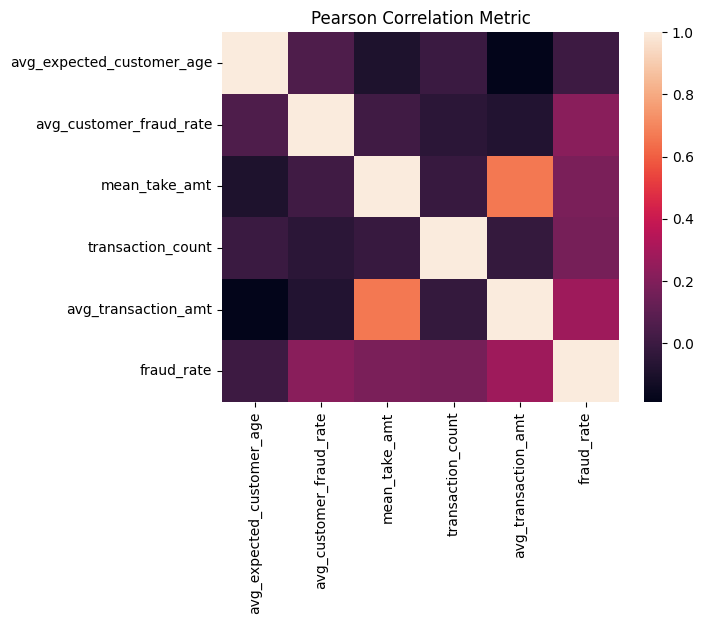

In [21]:
sns.heatmap(ranking_properties.corr())

plt.title('Pearson Correlation Metric')
plt.savefig('../plots/ranking_features_correlation.png', bbox_inches='tight')
plt.show()

Remove average transaction amount because it is correlated with mean take amount and fraud rate. We do not want to use correlated features for ranking because this will effectively increase the weight of these features.



In [22]:
ranking_properties = ranking_properties.drop('avg_transaction_amt', axis = 1)

<h3>Set-up for Different Ranking Methods<h3>

<h4>Weighted Average Rank<h4>

Calculate percentile ranking on each feature for every merchant

In [23]:
# Set whether we want to rank feature in ascending or descending order (if we prefer feature lower or higher)
ascending = {'avg_expected_customer_age': True, 'avg_customer_fraud_rate': True, 'mean_take_amt': False, 'transaction_count': False, 'fraud_rate': True}

# Get ranking on each feature for every merchant
ranks = []

for col_name in ranking_properties.columns:
    ranking_properties[col_name + '_rank'] = ranking_properties[col_name].rank(ascending = ascending[col_name], pct = True)
    ranks.append(col_name + '_rank')
merchant_percent_ranks = ranking_properties[ranks]
ranking_properties = ranking_properties.drop(ranks, axis = 1)

<h4>Weighted Normalised Ranking<h4>

Calculate normalised value for all features (between 0 and 1)

In [24]:
merchant_normalised_features = (ranking_properties-ranking_properties.min())/(ranking_properties.max()-ranking_properties.min())

Change features that we want to be lower so that they are negative (thus, when we use weights to sum values maximum sum will be best)

In [25]:
for col_name in merchant_normalised_features:
    if ascending[col_name]:
        merchant_normalised_features[col_name] = -1*merchant_normalised_features[col_name]

<h3>Interactive Ranking System<h3>

In [26]:
# Set initial weights

w1 = 0.1
w2 = 0.4
w3 = 1
w4 = 0.75
w5 = 0.4

ranking_type = 'weighted normalised ranking'

In [27]:
from ipywidgets import interact_manual, widgets, Layout

def weighted_average_rank(w1, w2, w3, w4, w5):
    merchant_percent_ranks['weighted_average_rank'] = w1*merchant_percent_ranks['avg_expected_customer_age_rank'] + w2*merchant_percent_ranks['avg_customer_fraud_rate_rank']\
         + w3*merchant_percent_ranks['mean_take_amt_rank'] + w4*merchant_percent_ranks['transaction_count_rank']\
             + w5*merchant_percent_ranks['fraud_rate_rank']
    merchant_percent_ranks['rank'] = merchant_percent_ranks['weighted_average_rank'].rank()
    merchant_ranking = merchant_percent_ranks.sort_values(by=['rank'])['rank'].to_frame()
    merchant_ranking = merchant_ranking.reset_index()
    merchant_ranking['merchant_abn'] = merchant_ranking['merchant_abn'].astype(int)
    merchant_ranking = merchant_ranking.merge(merchant_names, on = 'merchant_abn', how = 'outer').set_index('rank')

    print(merchant_ranking.head(20))

def weighted_normalised_rank(w1, w2, w3, w4, w5):
    merchant_normalised_features['weighted_normalised_value'] = w1*merchant_normalised_features['avg_expected_customer_age'] + w2*merchant_normalised_features['avg_customer_fraud_rate']\
         + w3*merchant_normalised_features['mean_take_amt'] + w4*merchant_normalised_features['transaction_count']\
             + w5*merchant_normalised_features['fraud_rate']
    merchant_normalised_features['rank'] = merchant_normalised_features['weighted_normalised_value'].rank(ascending = False)
    merchant_ranking = merchant_normalised_features.sort_values(by=['rank'])['rank']
    merchant_ranking = merchant_ranking.reset_index()
    merchant_ranking['merchant_abn'] = merchant_ranking['merchant_abn'].astype(int)
    merchant_ranking = merchant_ranking.merge(merchant_names, on = 'merchant_abn', how = 'outer').set_index('rank')
    print(merchant_ranking.head(20))
    print(merchant_ranking.loc[merchant_ranking['name'] == 'Elit Dictum Eu Foundation'])
    

def update(customer_age_weight=w1, customer_fraud_weight=w2, mean_take_amt_weight=w3, transaction_count_weight=w4, fraud_rate_weight=w5,ranking_strategy=ranking_type):
    if ranking_strategy == 'weighted average rank':
        weighted_average_rank(customer_age_weight, customer_fraud_weight, mean_take_amt_weight, transaction_count_weight, fraud_rate_weight)
    elif ranking_strategy == 'weighted normalised ranking':
        weighted_normalised_rank(customer_age_weight, customer_fraud_weight, mean_take_amt_weight, transaction_count_weight, fraud_rate_weight)
    return

im = interact_manual(update, customer_age_weight=(0, 1.0, 0.01), customer_fraud_weight=(0, 1.0, 0.01), mean_take_amt_weight=(0, 1.0, 0.01), \
    transaction_count_weight=(0, 1.0, 0.01), fraud_rate_weight=(0, 1.0, 0.01), ranking_strategy=['weighted average rank', 'weighted normalised ranking']);

descriptions = ['Customer Age Weight----', 'Customer Fraud Weight--', 'Take Amount Weight-----', 'Transaction Count Weight', 'Merchant Fraud Weight---']

for i in range(0,5):
    im.widget.children[i].style = {'description_width': 'initial'}
    im.widget.children[i].layout = Layout(width = '45%')
    im.widget.children[i].description = descriptions[i]

im.widget.children[5].description = 'Ranking Strategy'
im.widget.children[5].style = {'description_width': 'initial'}
im.widget.children[6].description = 'Find Ranking'

display(im)

interactive(children=(FloatSlider(value=0.1, description='customer_age_weight', max=1.0, step=0.01), FloatSlid…

<function __main__.update(customer_age_weight=0.1, customer_fraud_weight=0.4, mean_take_amt_weight=1, transaction_count_weight=0.75, fraud_rate_weight=0.4, ranking_strategy='weighted normalised ranking')>